In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
import absorption_line_vel as vel
from absorption_line_vel import SpectrumSN_Lines, AbsorbLine

# read spec data
z = 0.0307
spec = '../../spectroscopy/SN2020jgb/host_20220331_Keck2_corrected.ascii'
Spec1 = SpectrumSN_Lines(spec, z)
Spec = SpectrumSN_Lines(spec, 0)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = '25'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.labelsize'] = '20'

# 20220331_Keck2

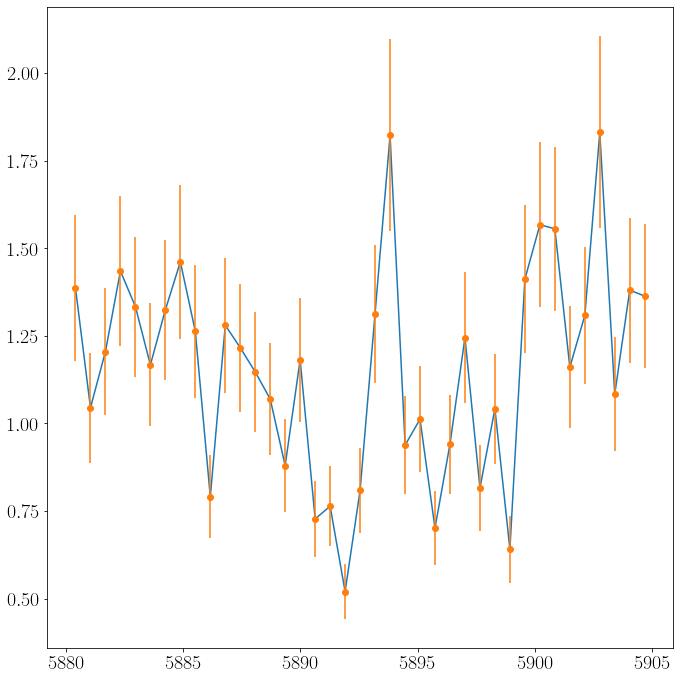

In [56]:
ax = Spec.plot_line_region(5880, 5905)

In [6]:
Spec.add_line('NaI_5896', 5880, 5905, lines=[5889.950, 5895.924], rel_strength=[2, 1])

LS estimation:
Velocity 1: 78 km/s
Normalize factor = 1.481


 10%|███▋                                 | 5000/50000 [00:34<05:14, 143.22it/s]

MCMC results:
Velocity 1: 85 pm 21 km/s


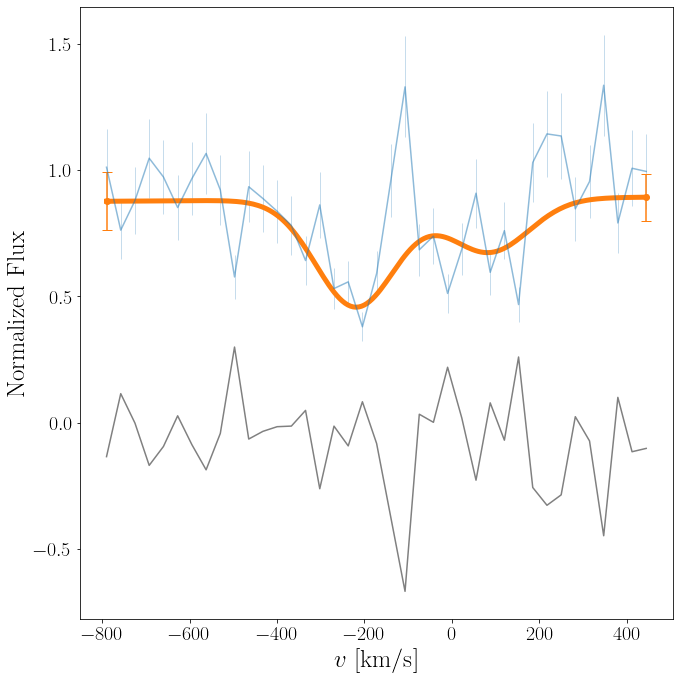

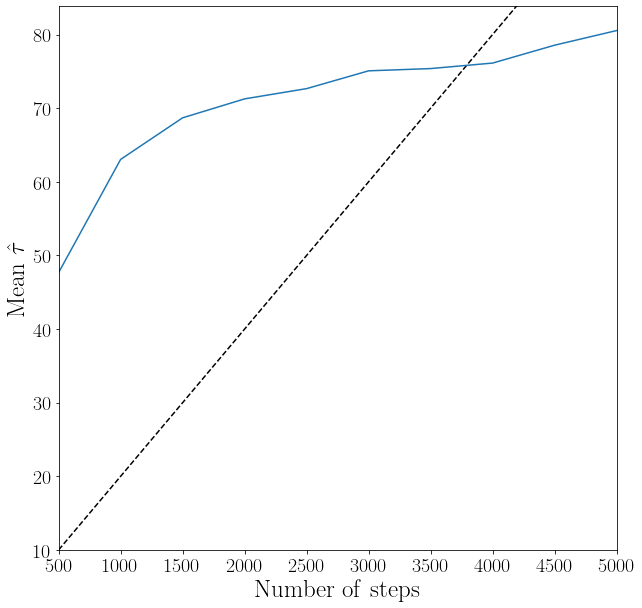

In [57]:
'''sampler = Spec.line['NaI_5896'].MCMC_sampler(initial=[1, 1, -100, 3, -5],
                                             normalize_unc=False,
                                             max_nsteps=1000)'''
Spec.line['NaI_5896'].LS_estimator(guess=(1, 1, 0, 8, -5))
sampler = Spec.line['NaI_5896'].MCMC_sampler(
    vel_flat=[-350, 350],
    #var_max=1e4,
    initial=[1, 1, 0, 8, -5],
    normalize_unc='LS',
    #Plot_mcmc=True,
    Plot_tau=True)

In [67]:
sample = sampler.get_chain(discard=700, flat=True, thin=1)
logprob = sampler.get_log_prob(discard=700, flat=True, thin=1)

Na = Spec.line['NaI_5896']
ratio = 2 / (Na.red_vel - Na.blue_vel) / (Na.red_fl[0]+Na.blue_fl[0])*\
            (Na.wv_line[-1] - Na.wv_line[0]) * np.sum(Na.rel_strength) * 1000
sig = np.exp(sample[:, -2] / 2)
EW = sample[:, -1] * -ratio
hist, bin_edges = np.histogram(EW, bins=100, density=True)
bins = (bin_edges[1:] + bin_edges[:-1]) / 2
width = bin_edges[1] - bin_edges[0]
arg = np.argsort(hist)

cred = 0.68  # credible region
dens_thres = np.inf
j = 0
while cred > 0:
    cred -= width * hist[arg[-1 - j]]
    dens_thres = hist[arg][-1 - j]
    j += 1
interval68 = bins[hist > dens_thres]

cred = 0.95-0.68  # credible region
while cred > 0:
    cred -= width * hist[arg[-1 - j]]
    dens_thres = hist[arg][-1 - j]
    j += 1
interval95 = bins[hist > dens_thres]

p1 = interval68[-1]
p2 = interval95[-1]

In [59]:
EBV1 = lambda EW: (2.47 * EW / 1000 - 1.76)
EBV2 = lambda EW: (2.16 * EW / 1000 - 1.91)
EBV = lambda EW: (1.17 * EW / 1000 - 1.85)

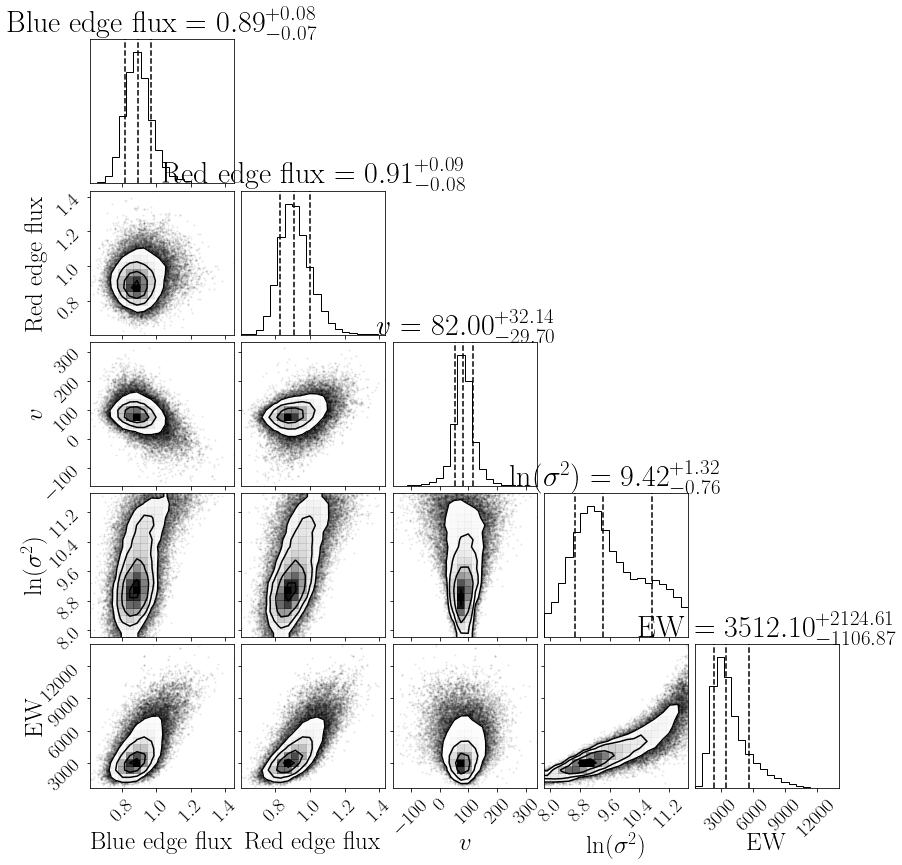

In [60]:
import corner
paramsNames = [
    r'$\mathrm{Blue\ edge\ flux}$', r'$\mathrm{Red\ edge\ flux}$', r'$v$',
    r'$\ln(\sigma^2)$', r'$\mathrm{EW}$'
]
chain = sample.copy()
chain[:, -1] = -ratio * chain[:, -1]
fig = corner.corner(chain[::7],
                    labels=paramsNames,
                    quantiles=[0.16, 0.50, 0.84],
                    show_titles=True)

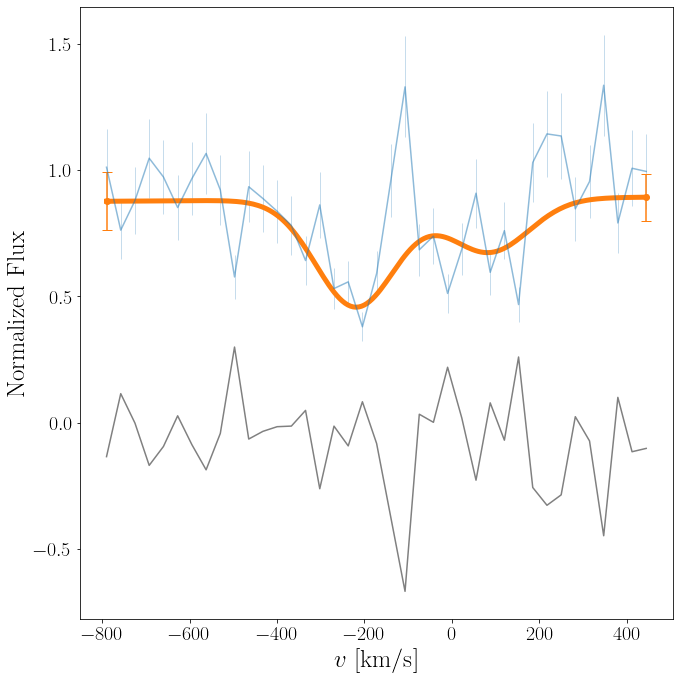

sigma = 91.4, EW = 3074.9, E(B-V) = 55.929


In [80]:
the = Na.theta_MCMC.copy()
Na.plot_model(the)
print('sigma = {:.1f}, EW = {:.1f}, E(B-V) = {:.3f}'.format(
    np.exp(the[-2] / 2), -ratio * the[-1], 10**EBV(-ratio * the[-1])))

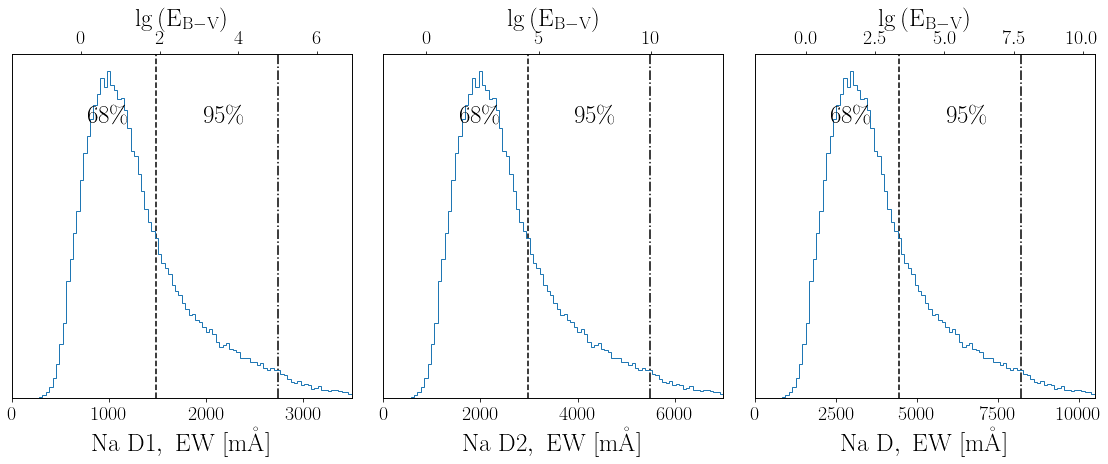

In [86]:
f, ax = plt.subplots(1, 3, figsize=(16, 7), sharey=True)
Range = 3500
ax[0].axvline(p1 / 3, color='k', linestyle='--')
ax[0].axvline(p2 / 3, color='k', linestyle='-.')
ax[0].text(p1 / 3 / Range / 3 + 0.08,
           0.8,
           r'$68\%$',
           transform=ax[0].transAxes)
ax[0].text(p2 / 3 / Range / 3 + 0.3,
           0.8,
           r'$95\%$',
           transform=ax[0].transAxes)
ax[0].hist(EW / 3, histtype='step', bins=100, range=[0, Range])
ax[0].set_xlabel(r'$\mathrm{Na\ D1,\ EW}\ [\mathrm{m\mathring{A}}]$')
ax02 = ax[0].twiny()
ax02.set_xlabel(r'$\lg\left(\mathrm{E_{\mathrm{B}-\mathrm{V}}}\right)$')
ax[0].set_xlim(0, Range)
ax02.set_xlim(EBV1(0), EBV1(Range))

ax[1].axvline(p1 * 2 / 3, color='k', linestyle='--')
ax[1].axvline(p2 * 2 / 3, color='k', linestyle='-.')
ax[1].text(p1 / 3 / Range / 3 + 0.08,
           0.8,
           r'$68\%$',
           transform=ax[1].transAxes)
ax[1].text(p2 / 3 / Range / 3 + 0.3,
           0.8,
           r'$95\%$',
           transform=ax[1].transAxes)
ax[1].hist(EW * 2 / 3, histtype='step', bins=100, range=[0, Range * 2])
ax[1].set_xlabel(r'$\mathrm{Na\ D2,\ EW}\ [\mathrm{m\mathring{A}}]$')
ax12 = ax[1].twiny()
ax12.set_xlabel(r'$\lg\left(\mathrm{E_{\mathrm{B}-\mathrm{V}}}\right)$')
ax[1].set_xlim(0, Range * 2)
ax12.set_xlim(EBV2(0), EBV2(Range * 2))

ax[2].axvline(p1, color='k', linestyle='--')
ax[2].axvline(p2, color='k', linestyle='-.')
ax[2].text(p1 / 3 / Range / 3 + 0.08,
           0.8,
           r'$68\%$',
           transform=ax[2].transAxes)
ax[2].text(p2 / 3 / Range / 3 + 0.3,
           0.8,
           r'$95\%$',
           transform=ax[2].transAxes)
ax[2].hist(EW, histtype='step', bins=100, range=[0, Range * 3])
ax[2].set_xlabel(r'$\mathrm{Na\ D,\ EW}\ [\mathrm{m\mathring{A}}]$')
ax22 = ax[2].twiny()
ax22.set_xlabel(r'$\lg\left(\mathrm{E_{\mathrm{B}-\mathrm{V}}}\right)$')
ax[2].set_xlim(0, Range * 3)
ax22.set_xlim(EBV(0), EBV(Range * 3))

ax[0].set_yticks([])
f.tight_layout()

## H$\alpha$

<AxesSubplot:>

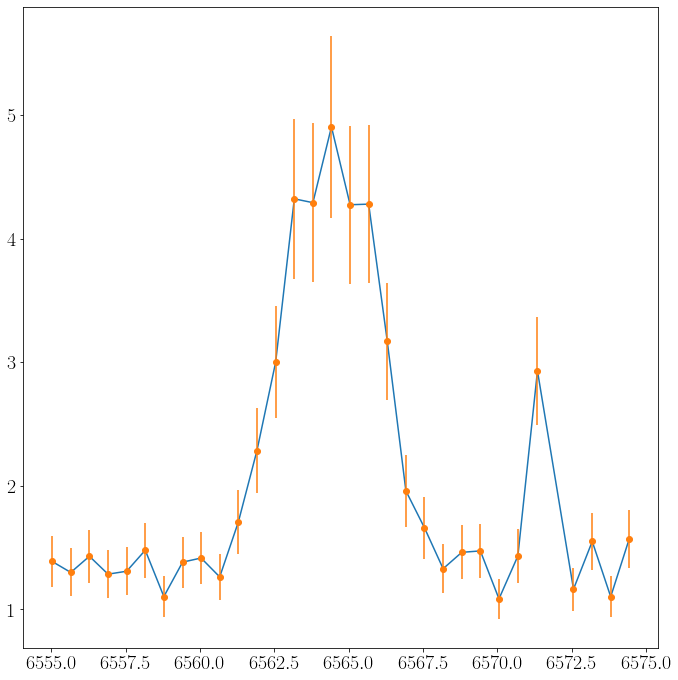

In [36]:
Spec1.plot_line_region(6555, 6575)

In [ ]:
Spec1.add_line('Halpha',
               6560,
               6570,
               lines=[[6562.79]],
               rel_strength=[[]])
Spec1.line['Halpha'].LS_estimator(guess=(1, 1, 0, 10, 100), plot_model=True)

Normalize factor = 0.515


 12%|████▋                                | 2500/20000 [00:15<01:45, 165.51it/s]


MCMC results:
Velocity 1: 72 pm 3 km/s


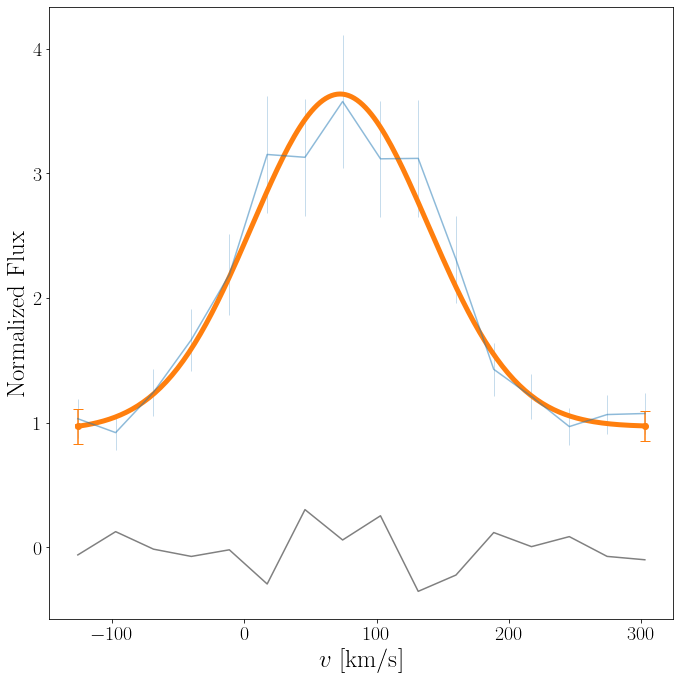

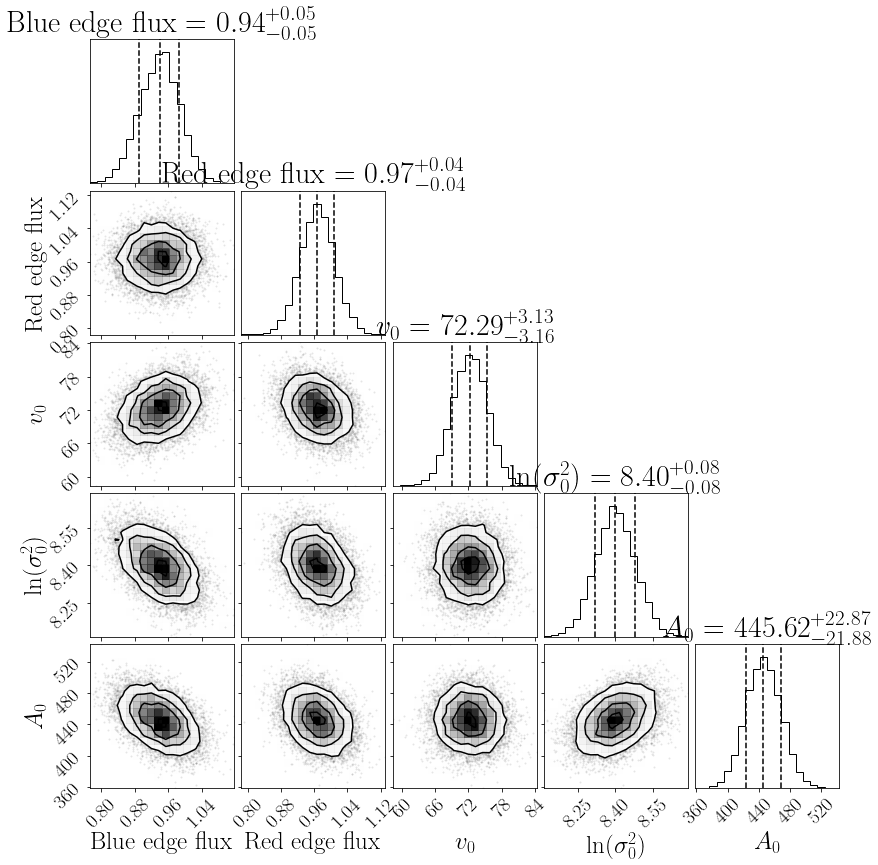

In [144]:
Spec1.line['Halpha'].MCMC_sampler(
    vel_flat=[-500, 500],
    initial=[],
    normalize_unc='LS',
    Plot_mcmc=True,
    max_nsteps=20000,
    Plot_tau=False)

In [145]:
Spec1.line['Halpha'].EW, Spec1.line['Halpha'].sig_EW

(-18.45197191340084, 0.8156606403243777)

## [N ii]

<AxesSubplot:>

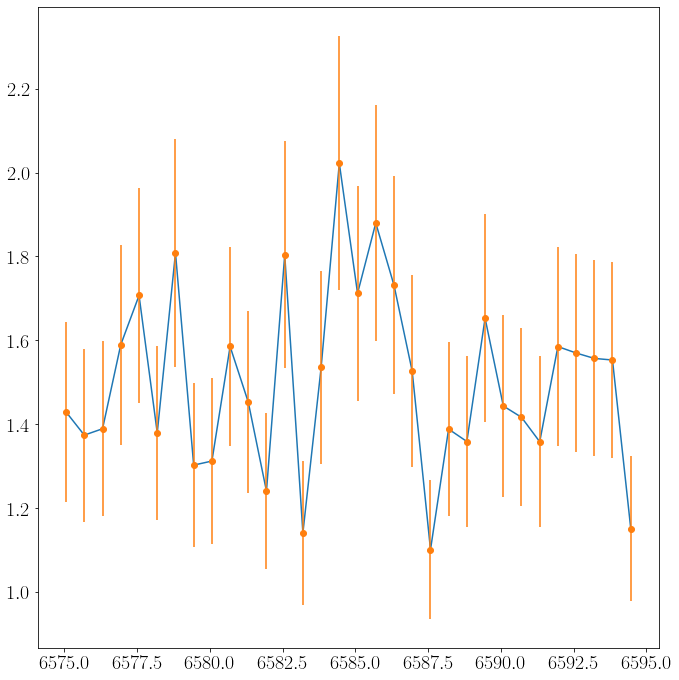

In [103]:
Spec1.plot_line_region(6575, 6595)

In [ ]:
Spec1.add_line('Nii',
               6575,
               6595,
               lines=[[6583]],
               rel_strength=[[]])
Spec1.line['Nii'].LS_estimator(guess=(1, 1, 100, 8, 100), plot_model=True)

Normalize factor = 0.820


 18%|██████▍                              | 3500/20000 [00:21<01:41, 163.14it/s]

MCMC results:
Velocity 1: 106 pm 16 km/s


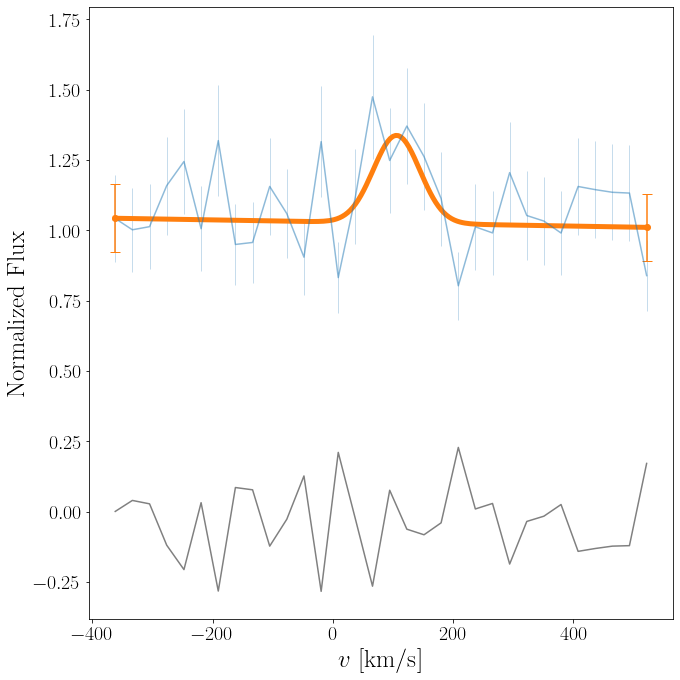

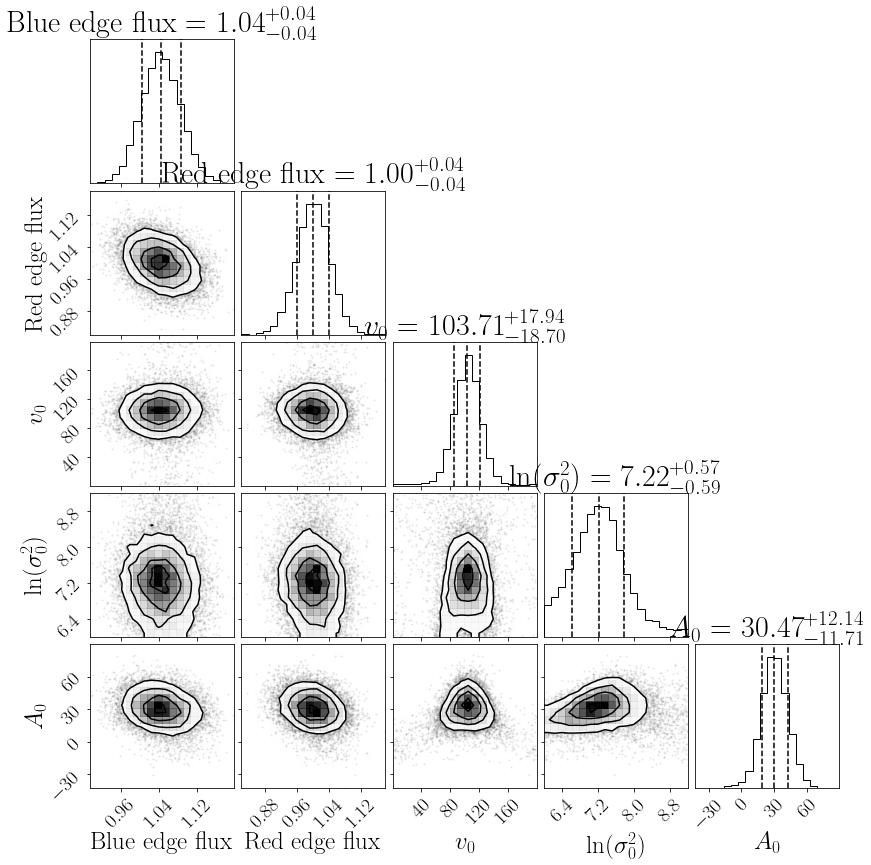

In [143]:
Spec1.line['Nii'].MCMC_sampler(
    vel_flat=[0, 200],
    var_max=1e6,
    initial=[],
    normalize_unc='LS',
    Plot_mcmc=True,
    max_nsteps=20000,
    Plot_tau=False)

In [146]:
Spec1.line['Nii'].EW, Spec1.line['Nii'].sig_EW

(-1.2889070712838047, 0.39564931162974964)

In [153]:
result = Spec1.line['Nii'].EW / Spec1.line['Halpha'].EW
sig = ((Spec1.line['Nii'].sig_EW / Spec1.line['Nii'].EW)**2 +
       (Spec1.line['Halpha'].sig_EW / Spec1.line['Halpha'].EW)**2) * result
print('lg [Oiii]/Hbeta = {:.2f}+{:.2f}-{:.2f}'.format(
    np.log10(result), np.log10(1 + sig / result), -np.log10(1 - sig / result)))

lg [Oiii]/Hbeta = -1.16+0.04-0.04


## H$\beta$

<AxesSubplot:>

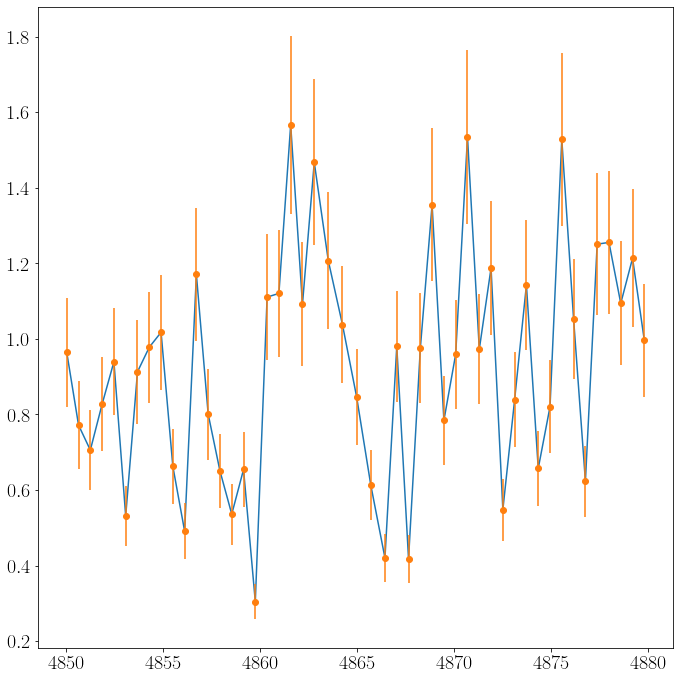

In [134]:
Spec1.plot_line_region(4850, 4880)

In [ ]:
Spec1.add_line('Hbeta',
               4853,
               4873,
               lines=[[4861]],
               rel_strength=[[]])
Spec1.line['Hbeta'].LS_estimator(guess=(1, 1, 100, 8, 100), plot_model=True)

Normalize factor = 2.421


 18%|██████▍                              | 3500/20000 [00:21<01:39, 165.51it/s]


MCMC results:
Velocity 1: 114 pm 34 km/s


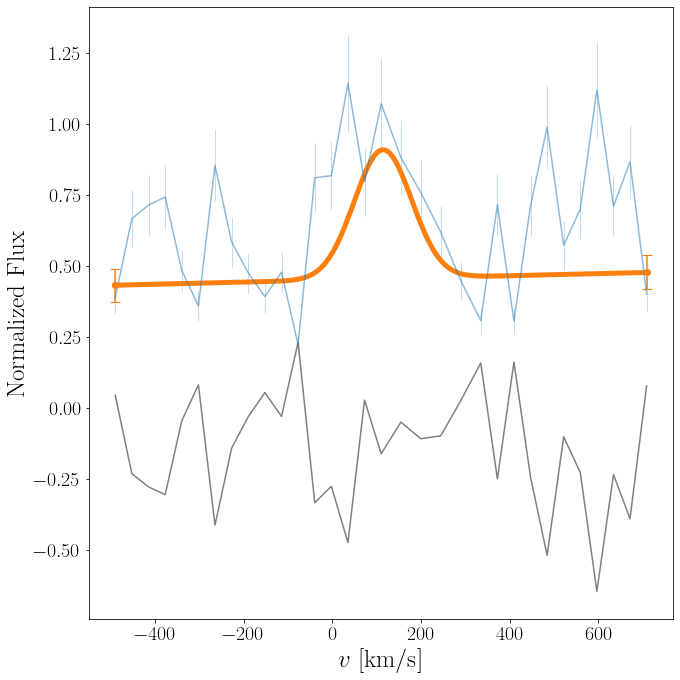

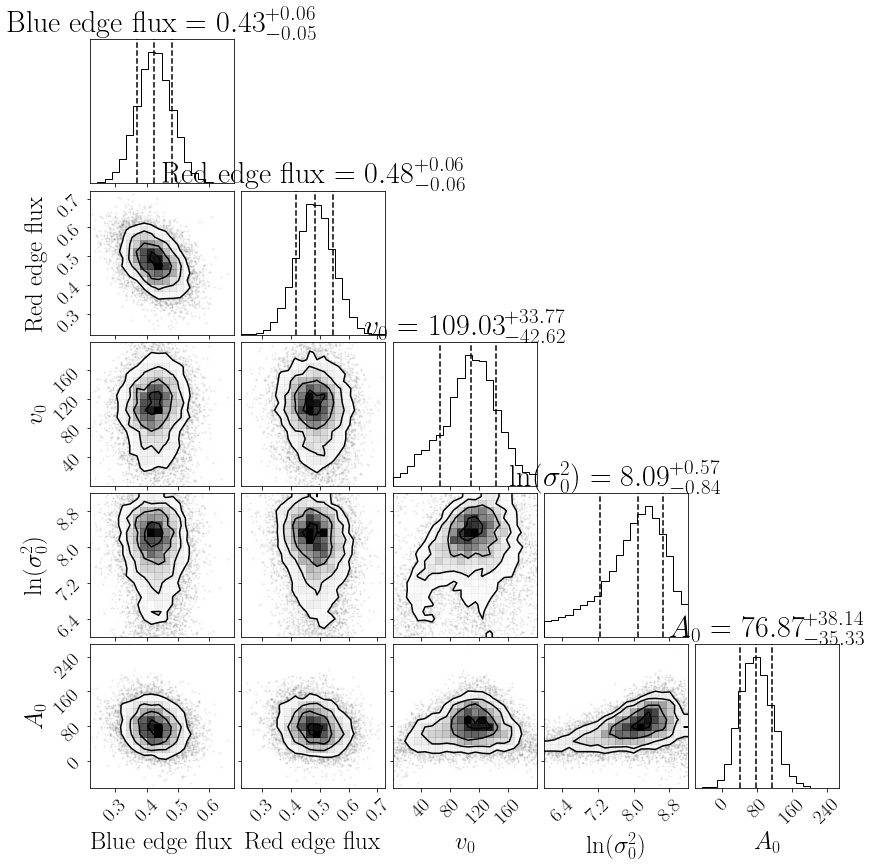

In [142]:
Spec1.line['Hbeta'].MCMC_sampler(
    vel_flat=[0, 200],
    var_max=1e6,
    initial=[],
    normalize_unc='LS',
    Plot_mcmc=True,
    max_nsteps=20000,
    Plot_tau=False)

In [150]:
Spec1.line['Hbeta'].EW, Spec1.line['Hbeta'].sig_EW

(-2.327421214836376, 1.005976471782817)

## [O iii]

<AxesSubplot:>

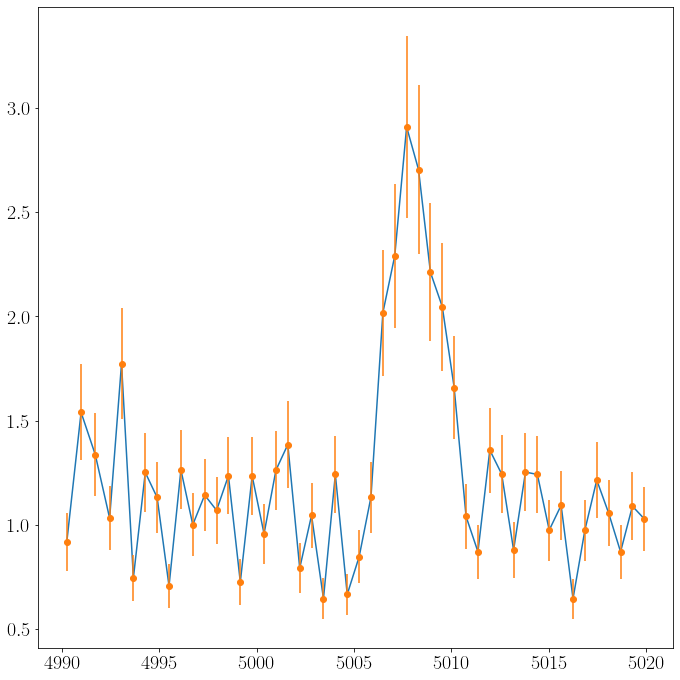

In [128]:
Spec1.plot_line_region(4990, 5020)

In [ ]:
Spec1.add_line('Oiii',
               5000,
               5015,
               lines=[[5007]],
               rel_strength=[[]])
Spec1.line['Oiii'].LS_estimator(guess=(1, 1, 100, 8, 100), plot_model=True)

Normalize factor = 1.366


 20%|███████▍                             | 4000/20000 [00:25<01:40, 159.57it/s]


MCMC results:
Velocity 1: 69 pm 10 km/s


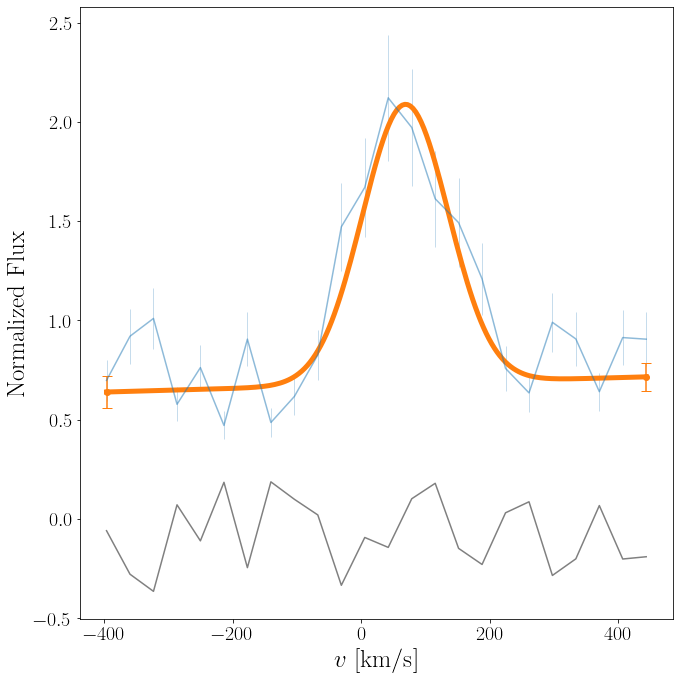

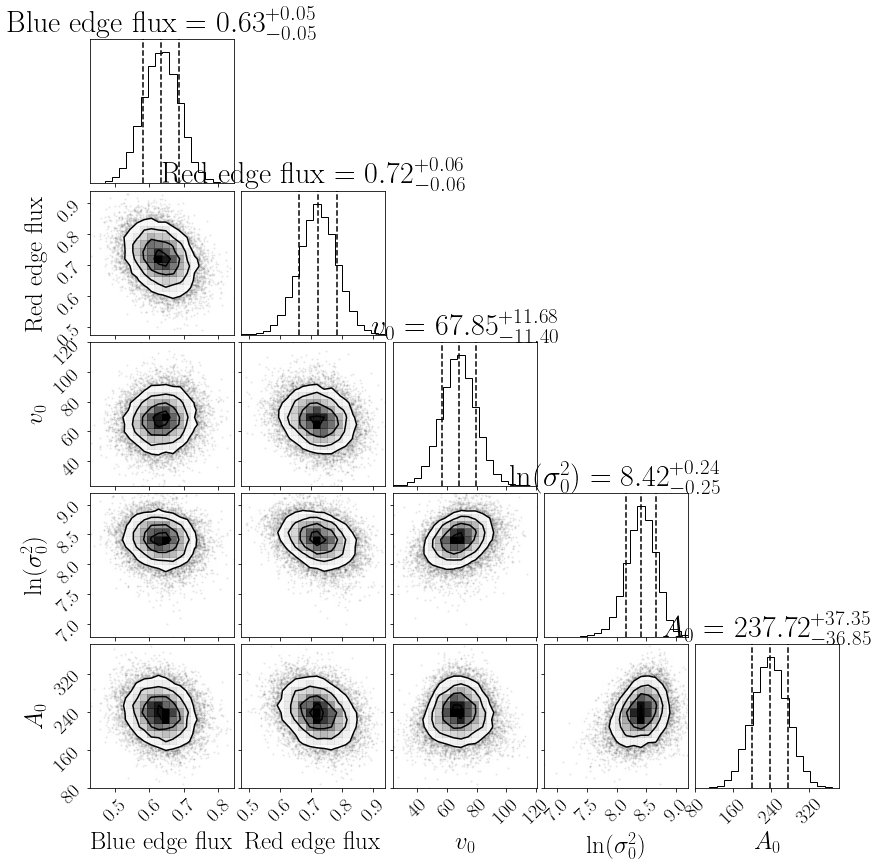

In [141]:
Spec1.line['Oiii'].MCMC_sampler(
    vel_flat=[0, 200],
    var_max=1e6,
    initial=[],
    normalize_unc='LS',
    Plot_mcmc=True,
    max_nsteps=20000,
    Plot_tau=False)

In [148]:
Spec1.line['Oiii'].EW, Spec1.line['Oiii'].sig_EW

(-7.384578628054777, 1.0137096487729462)

In [152]:
result = Spec1.line['Oiii'].EW / Spec1.line['Hbeta'].EW
sig = ((Spec1.line['Oiii'].sig_EW / Spec1.line['Oiii'].EW)**2 +
       (Spec1.line['Hbeta'].sig_EW / Spec1.line['Hbeta'].EW)**2) * result
print('lg [Oiii]/Hbeta = {:.2f}+{:.2f}-{:.2f}'.format(
    np.log10(result), np.log10(1 + sig / result), -np.log10(1 - sig / result)))

lg [Oiii]/Hbeta = 0.50+0.08-0.10
